In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import math
import os
from pathlib import Path
import sys

In [3]:
from PIL import Image as PILImage
from PIL import ImageChops as PILImageChops
from fastai import *
from fastai.vision import *
from fastai.vision.transform import *
from fastai.vision.image import TfmAffine
from fastai.metrics import accuracy
from torchvision.transforms import functional as vision_transform

In [4]:
parent_dir = Path.cwd().parent.as_posix()
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [5]:
from basedir import PREPARED, TEST
from dataset import QuickDraw, TestImagesFolder
from logger import get_logger
from utils import Predictor, Timer

In [6]:
defaults.device = torch.device('cuda:0')
log = get_logger(log_path='log.txt')
IMG_SIZE = 128, 128

In [7]:
trn_ds = QuickDraw(PREPARED, train=True, subset_size=200, img_size=IMG_SIZE, log=log)
val_ds = QuickDraw(PREPARED, train=False, subset_size=50, img_size=IMG_SIZE, log=log)
tst_ds = TestImagesFolder(TEST, img_size=IMG_SIZE)

[2018/11/16 17:38:16:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/train_200.feather
[2018/11/16 17:38:16:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/valid_50.feather


In [8]:
def create_bunch(train_path=PREPARED, test_path=TEST, subset_sizes=(200, 50), 
                 img_size=IMG_SIZE, bs=800, ds_tfms=None):
    trn_sz, val_sz = subset_sizes
    trn_ds = QuickDraw(train_path, train=True, subset_size=trn_sz, img_size=img_size, log=log)
    val_ds = QuickDraw(train_path, train=False, subset_size=val_sz, img_size=img_size, log=log)
    tst_ds = TestImagesFolder(test_path, img_size=img_size)
    bunch = ImageDataBunch.create(trn_ds, val_ds, tst_ds, bs=bs, num_workers=4, ds_tfms=ds_tfms)
    bunch.normalize(imagenet_stats)
    bunch.show_batch(rows=4)
    return bunch

In [9]:
def trim(img):
    bg = PILImage.new(img.mode, img.size, color='black')
    diff = PILImageChops.difference(img, bg)
    diff = PILImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        img = img.crop(bbox)
    return img

In [10]:
@TfmCrop
def strip_empty_space(x, size, **kwargs):
    """Crops the image to exclude empty space from the image and rescale it to oritinal size."""

    img = vision_transform.to_pil_image(x)
    trimmed = trim(img).resize(size)
    new = vision_transform.to_tensor(trimmed).to(x)
    return new

In [11]:
def mapk(y_pred, y_true, k):
    """Precision metric which compares several guesses with a single ground-truth value.
    
    Adapted from:
        https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
        
    """
    top_k = y_pred.argsort(descending=True)[:, :k]
    matched = top_k == y_true.view(-1, 1)
    map_k = 1/(matched.argmax(dim=1) + 1).float()
    return map_k.mean()

In [12]:
# Custom implementation of fastai's build-in functionality
#
# def show_batch(data_bunch, ds_type=DatasetType.Train, n=9, **fig_kwargs):
#     dl = data_bunch.dl(ds_type)
#     index = next(iter(dl.batch_sampler))[:n]
#     rows = int(math.sqrt(len(index)))
#     cols = n // rows
#     ds = dl.dataset
#     images = [ds[i][0] for i in index]
#     f, axes = plt.subplots(rows, cols, **fig_kwargs)
#     for img, ax in zip(images, axes.flat):
#         ax.imshow(img.data.permute(1, 2, 0))
#         ax.set_axis_off()

[2018/11/16 17:38:18:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/train_200.feather
[2018/11/16 17:38:19:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/valid_50.feather


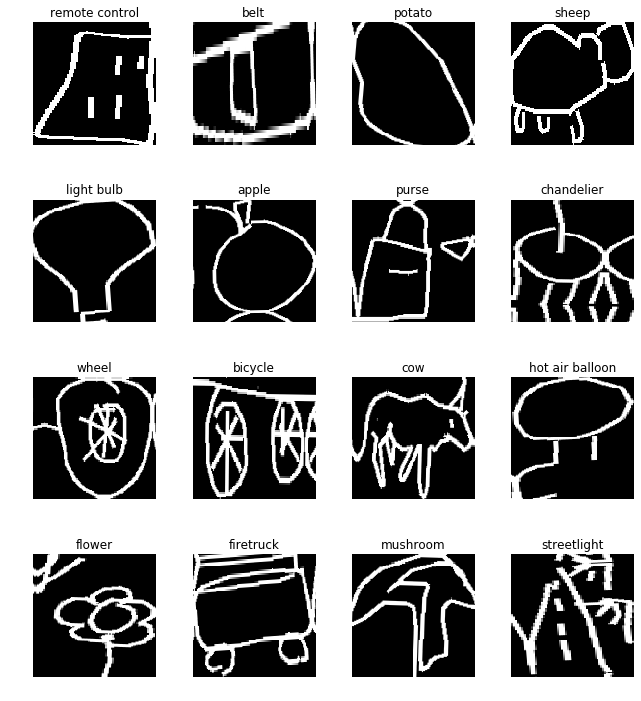

In [13]:
train_tfms = [
    strip_empty_space(),
    rand_crop(padding_mode='zeros'),
    flip_affine(p=0.5),
    rotate(degrees=(-5, 5), p=0.75),
    rand_zoom(scale=(0.8, 1.1), p=0.5)
]

valid_tfms = [
    strip_empty_space(),
    crop_pad(padding_mode='zeros')
]

bunch = create_bunch(ds_tfms=(train_tfms, valid_tfms))

In [14]:
learn = create_cnn(bunch, models.resnet18)
learn.metrics = [accuracy, partial(mapk, k=3)]

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


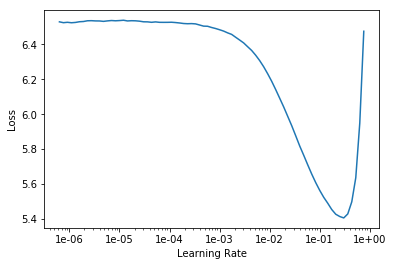

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(1, max_lr=1e-02)

Total time: 01:09
epoch  train_loss  valid_loss  accuracy  mapk    
1      3.056311    2.005485    0.500882  0.880824  (01:09)



In [53]:
learn.fit_one_cycle(3, max_lr=1e-02 / 2)

Total time: 03:27
epoch  train_loss  valid_loss  accuracy  mapk    
1      2.192384    1.789899    0.542059  0.880019  (01:07)
2      1.991988    1.556604    0.596176  0.888382  (01:09)
3      1.784793    1.478281    0.613882  0.890814  (01:09)



In [57]:
learn.save('base')

In [15]:
_ = learn.load('base')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


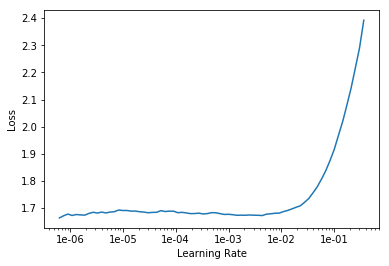

In [16]:
learn.unfreeze()
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, max_lr=slice(2e-04, 1e-03))

Total time: 05:37
epoch  train_loss  valid_loss  accuracy  mapk    
1      1.683073    1.454983    0.618294  0.891441  (01:07)
2      1.661839    1.431157    0.623412  0.892186  (01:05)
3      1.628744    1.409645    0.628412  0.892902  (01:06)
4      1.585258    1.397181    0.629412  0.893137  (01:09)
5      1.562858    1.393957    0.630471  0.893824  (01:07)



In [25]:
learn.save('unfreeze_one')

In [27]:
_ = learn.load('unfreeze_one')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


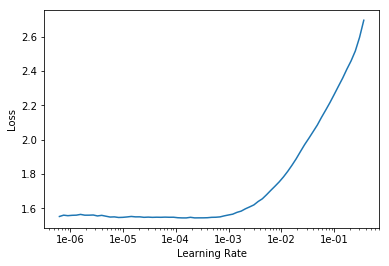

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, max_lr=slice(1e-04, 3e-04))

Total time: 03:59
epoch  train_loss  valid_loss  accuracy  mapk    
1      1.525706    1.338248    0.641235  0.893559  (00:47)
2      1.447677    1.268537    0.656647  0.896108  (00:47)
3      1.321203    1.191543    0.672824  0.897480  (00:47)
4      1.194460    1.140499    0.689765  0.902147  (00:48)
5      1.112361    1.128053    0.692412  0.901245  (00:47)



In [31]:
learn.save('unfreeze_all')

In [32]:
_ = learn.load('unfreeze_all')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


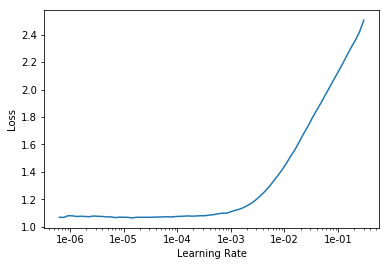

In [40]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(10, max_lr=slice(1e-05, 5e-04))

Total time: 10:52
epoch  train_loss  valid_loss  accuracy  mapk    
1      1.080491    1.119612    0.693059  0.902196  (00:47)
2      1.072724    1.118110    0.694529  0.902000  (00:53)
3      1.058449    1.114026    0.694647  0.902745  (01:09)
4      1.022754    1.101423    0.697941  0.903098  (01:06)
5      0.989147    1.090116    0.701059  0.902676  (01:08)
6      0.934668    1.077882    0.704353  0.903333  (01:07)
7      0.881932    1.067467    0.707000  0.905206  (01:10)
8      0.848665    1.061321    0.709353  0.905843  (01:10)
9      0.822792    1.057397    0.709882  0.905382  (01:09)
10     0.807711    1.056709    0.709941  0.905461  (01:08)



In [64]:
learn.save('full')
_ = learn.load('full')

In [42]:
tta = learn.TTA(ds_type=DatasetType.Test)

Total time: 15:14



In [48]:
preds, _ = tta

In [57]:
preds, _ = learn.get_preds(DatasetType.Test)

In [49]:
preds.shape

torch.Size([112199, 340])

In [58]:
keys = [path.stem for path in tst_ds.images]

In [59]:
def top_k(learn, logits, k=3):
    top_idx = logits.argsort()[:, -k:]
    top_classes = learn.data.classes[top_idx]
    top_logits = logits[np.arange(len(logits)), top_idx.T].T
    return np.fliplr(top_classes), np.fliplr(top_logits)

In [60]:
def generate_submission_file(keys, classes, filename='submit.csv'):
    records = ['key_id,word']

    for key, top_classes in zip(keys, classes):
        str_classes = ' '.join(['_'.join(c.split()) for c in top_classes])
        records.append(f'{key},{str_classes}')

    with open('submit.csv', 'w') as file:
        for record in records:
            file.write(record + '\n')

In [61]:
classes, logits = top_k(learn, to_np(preds))

In [62]:
generate_submission_file(keys, classes)

In [63]:
!kaggle competitions submit  quickdraw-doodle-recognition -f submit.csv -m "ResNet18 super tuned"

100%|██████████████████████████████████████| 4.39M/4.39M [00:04<00:00, 1.06MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge